In [1]:
import data_reader, data_analyser
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'), sep=',')

da = data_analyser.DataAnalyser()

In [3]:
k_values, ip = da.get_k_values(choices, log=True)
k_values_long = da.get_long_k_values(k_values, choices)

bias = da.get_ss_bias(data_path)
k_values = k_values.join(bias.set_index('subj_id'), on='subj_id')
k_values_long = k_values_long.join(bias.set_index('subj_id'), on='subj_id')
k_values['k_diff'] = k_values.walking - k_values.mouse

# Basic k-value analysis

-0.013623970564253086


Ttest_1sampResult(statistic=-0.7170517912862284, pvalue=0.47637638966019724)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


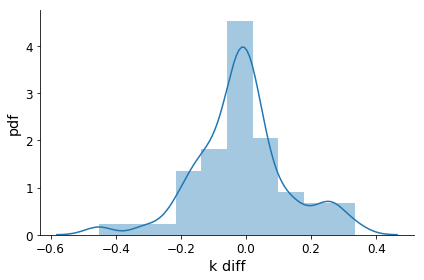

In [54]:
g = sns.distplot(k_values.k_diff, bins=10)
g.axes.set_xlabel('k diff')
g.axes.set_ylabel('pdf')
print(k_values.k_diff.mean())

from scipy.stats import ttest_1samp

ttest_1samp(k_values.k_diff, popmean=0)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


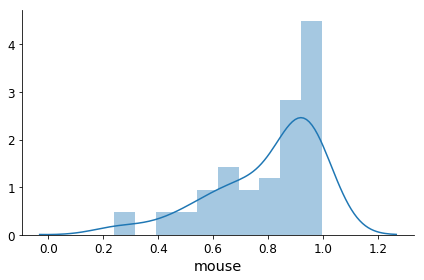

In [55]:
g = sns.distplot(k_values.mouse, bins=10)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


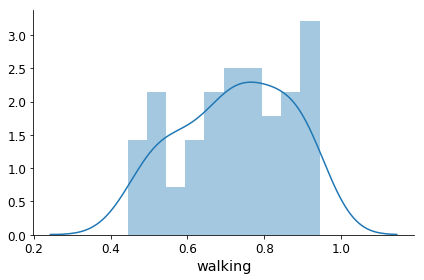

In [51]:
g = sns.distplot(k_values.walking, bins=10)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


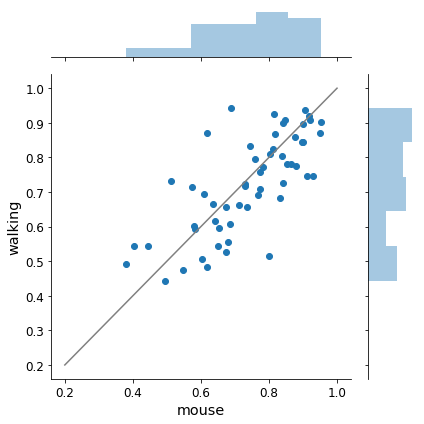

In [60]:
g = sns.jointplot(data=k_values, x='mouse', y='walking')
x = np.linspace(0.2, 1)
g.ax_joint.plot(x, x, color='grey')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


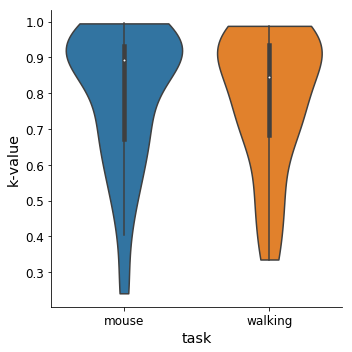

In [12]:
# sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index(), 
#             x='task', y='k-value', kind='violin')

ax = sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'), 
                 x='task', y='k-value', 
                 kind='violin', cut=0)
# ax = sns.stripplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'),
#                    x='task', y='k-value',
#                    size=4, jitter=0.05, color="gray")

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


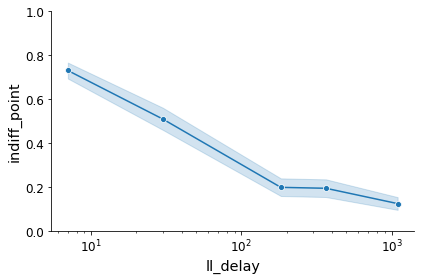

In [7]:
ax = sns.lineplot(data=ip, x='ll_delay', y='indiff_point'
#                   , hue='task', style='task', 
                  , marker='o', markers=True
                 )
ax.set_ylim(0, 1)
sns.despine()
ax.set_xscale('log')
plt.savefig('discounting_log.png')

# Task effect might depending on individuals' k?

It seems that the effect of task might be individual-specific. E.g., people might not universally choose more SS in the walking task, but they might choose their default option more often in that task

In [21]:
k_values['bias'] = k_values.SS_bias>0

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


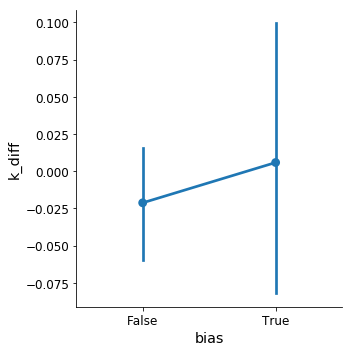

In [26]:
sns.catplot(data=k_values, x='bias', y='k_diff', kind='point')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


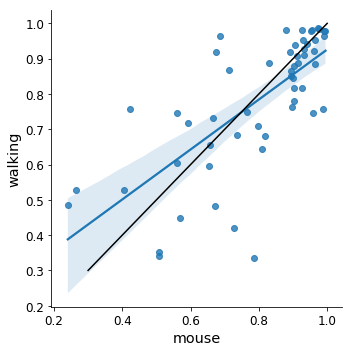

In [17]:
f = sns.lmplot(data=k_values, x='mouse', y='walking', truncate=True)
x = np.linspace(0.3, 1.0)
f.ax.plot(x, x, color='k')